# Portfolio Management Project

## Objective: 
In this project, we aim to build stylized long-short equity factor mimicking portfolios using different fundamental variables from Ken French’s data library and explore empirically their univariate efficacy over time and across different size segments. We then go on to build multi-factor strategies using alternative weighting schemes and compare them to the static equally weighted multi-factor strategy. Two alternative top-down factor weighting schemes will be considered: 1) Equal risk contribution across factors 2) Weighting based on factor persistence

## Data: 
Attached with the project description are 6 csv files containing the monthly time series of value- and equal-weighted returns for portfolios formed on size and different fundamental variables consisting of book-to-price, cashflow-to-price, dividend yield, investment, profitability, prior 1-month return and 12-1 price momentum. In addition, there is a csv file named “F-F_Research_Data_Factors” which houses the Fama-French 3 factor model returns.

## Project description:

1.For each of the six fundamental variables, construct long-short factor mimicking portfolios and plot their historical performance across different size segments. Taking the market return from Fama-French’s 3-factor model, calculate and plot the rolling 3-year market beta for these stylized portfolios. Considering both size segments, construct a beta-neutral factor mimicking portfolio for each fundamental variable. Comment on your results. 

2.Calculate the full sample correlation matrix of unadjusted factor returns (i.e. not the beta-neutral version) derived from 1. Comment on your findings. Using a lookback period of 5 years, employ an equal risk contribution factor weighting strategy with monthly rebalancing. The monthly resultant portfolios should be dollar neutral with a long leg exposure of 100%. Plot the monthly factor weights over time and evaluate the strategy performance against the static equally weighted factor portfolio. Comment on your results. 

3.Using different lookback periods of 1,12 and 36 months to determine factor persistence, build adaptive multi-factor models that appropriately reflect your view on each factor. For example, you may want to consider a factor weighting approach such that the factor allocation is proportional to the historical Sharpe ratio for a given lookback period. Comment on your results.


### Data Source:
Fama-Frence Libary

### Factors:
BP: book value / stock price

CFP: cash flow / stock price

DP: dividend / stock price

INV: investment value

MOMENTUM_PRIOR_1: short-term reversal, return for prior 1 month

MOMENTUM_PRIOR_12_2: short-term momentum, return for prior 12 month to prior 2 month


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import linprog
from scipy.optimize import minimize
import pymprog
from statsmodels import regression
import statsmodels.api as sm
import statsmodels.formula.api as smf


def long_short(filename,buy_high=True):
    data = pd.read_csv(filename)
    data['Month'] = pd.to_datetime(data['Month'],format ='%Y%m')
    data = data.set_index('Month')
    
    if buy_high:
        data['SMALL'] = (data.iloc[:,2] - data.iloc[:,0])
        data['BIG'] = (data.iloc[:,5] - data.iloc[:,3])
    
    else:
        data['SMALL'] = (-data.iloc[:,2] + data.iloc[:,0])
        data['BIG'] = (-data.iloc[:,5] + data.iloc[:,3])
    
    return data


def beta(data,market_data):
    data['MARKET'] = market_data['MARKET'] 
    column_beta = [data.columns[i] for i in [0,2,3,5,6,7]]
    a=[]
    for i in column_beta:     
        a.append(i+'_BETA')
        data[i+'_BETA'] = pd.rolling_cov(data[i],data['MARKET'],window=36)/pd.rolling_var(data['MARKET'],window=36)
    
    for i in column_beta[:4]:
        data[i+'_ALPHA'] = data[i] -data[i+'_BETA']* data['MARKET']
        
    return data.dropna(),a[:4]

def beta_neutral_2(data,a,buy_high=True):

    b = [j[:-5]+'_ALPHA' for j in a]
    c = [j[:-5] for j in a]
    performance=[]
    for i in range(len(data)-1):
        beta1,beta2,beta3,beta4= data.iloc[i][a]
        alpha1,alpha2,alpha3,alpha4 = data.iloc[i][b]
        r1,r2,r3,r4 = data.iloc[i+1][c]
        
        target = np.array([alpha1,alpha2,alpha3,alpha4])
        
        if buy_high:
            
            results = linprog(-target,
                              A_eq=[[beta1,beta2,beta3,beta4],[1,0,1,0],[0,1,0,1]],
                              b_eq=[0,-1,1],
                              bounds=((-1,0),(0,1),(-1,0),(0,1)))
            
            if not 'successfully' in results.message:
                cons = ({'type': 'eq', 'fun': lambda p:beta1*p[0]+beta2*p[1]+beta3*p[2]+beta4*p[3]},
                        {'type': 'eq', 'fun': lambda p:p[1]+p[3]-1},
                        {'type': 'eq', 'fun': lambda p:p[0]+p[2]+1},
                        {'type': 'ineq', 'fun': lambda p:p[0]+1},
                        {'type': 'ineq', 'fun': lambda p:p[2]+1},
                        {'type': 'ineq', 'fun': lambda p:1-p[1]},
                        {'type': 'ineq', 'fun': lambda p:1-p[3]})
            
                results = minimize(fun=alpha_sum, 
                                   x0=[0,0,0,0],  
                                   method='SLSQP',  
                                   constraints=cons,
                                   args=(alpha1,alpha2,alpha3,alpha4)) 
                
            
        
        else:
            results = linprog(-target,
                              A_eq=[[beta1,beta2,beta3,beta4],[1,0,1,0],[0,1,0,1]],
                              b_eq=[0,1,-1],
                              bounds=((0,1),(-1,0),(0,1),(-1,0)))
            if not 'successfully' in results.message:
                cons = ({'type': 'eq', 'fun': lambda p:beta1*p[0]+beta2*p[1]+beta3*p[2]+beta4*p[3]},
                        {'type': 'eq', 'fun': lambda p:p[0]+p[2]-1},
                        {'type': 'eq', 'fun': lambda p:p[1]+p[3]+1},
                        {'type': 'ineq', 'fun': lambda p:p[1]+1},
                        {'type': 'ineq', 'fun': lambda p:p[3]+1},
                        {'type': 'ineq', 'fun': lambda p:1-p[0]},
                        {'type': 'ineq', 'fun': lambda p:1-p[2]})
            
            
                results = minimize(fun=alpha_sum, 
                                   x0=[0,0,0,0], 
                                   method='SLSQP', 
                                   constraints=cons,
                                   args=(alpha1,alpha2,alpha3,alpha4))

            
            
        rho1,rho2,rho3,rho4 = list(results.x)
        
        performance.append(r1*rho1+r2*rho2+r3*rho3+r4*rho4)
    
    output=pd.DataFrame()
    output['Beta_Neutral_Performance'] = pd.Series(performance)
    output.index = data.index[1:]
        
    return output


def alpha_sum(p,alpha1,alpha2,alpha3,alpha4):
    return -(alpha1*p[0]+alpha2*p[1]+alpha3*p[2]+alpha4*p[3])


def erc(df,look_back):
    origin_columns = list(df.columns)
    
    cov_name = []
    data=pd.DataFrame()
    data[origin_columns] = df[origin_columns]
    for a in origin_columns:
        for b in origin_columns:
            data[a+'_'+b+'_cov'] = df[a].rolling(window=look_back).cov(df[b])
            cov_name.append(a+'_'+b+'_cov')
            
    data = data.dropna()
    erc_df = data[origin_columns]
    
    x1=[]
    x2=[]
    x3=[]
    x4=[]
    x5=[]
    x6=[]
    x7=[]

    
    for i in range(len(data)):
        cov_array = np.array(data.iloc[i][cov_name])
        cons = ({'type': 'eq', 'fun': lambda x:x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6]-1})
        results = minimize(fun=erc_target, x0=[0,0,0,0,0,0,0],  method='SLSQP', 
                            constraints=cons,args=cov_array,bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))) 
        
        x1.append(list(results.x)[0])
        x2.append(list(results.x)[1])
        x3.append(list(results.x)[2])
        x4.append(list(results.x)[3])
        x5.append(list(results.x)[4])
        x6.append(list(results.x)[5])
        x7.append(list(results.x)[6])
        

    weights_columns = [f+'_weight' for f in origin_columns]
    x_all = [x1,x2,x3,x4,x5,x6,x7]
    for num in range(7):
        weights_columns = [f+'_weight' for f in origin_columns]

        erc_df[weights_columns[num]] = pd.Series(x_all[num],index=erc_df.index)
    
    simple_list = []
    erc_list=[]
        
    for i in range(len(erc_df)-1):
        simple_list.append(sum(erc_df.iloc[i+1][origin_columns])/7)
        
        w1 = x1[i]
        w2 = x2[i]
        w3 = x3[i]
        w4 = x4[i]
        w5 = x5[i]
        w6 = x6[i]
        w7 = x7[i]
        
        r1,r2,r3,r4,r5,r6,r7 = erc_df.iloc[i+1][origin_columns]
        
        erc_list.append(w1*r1+w2*r2+w3*r3+w4*r4+w5*r5+w6*r6+w7*r7)
    
    return erc_df,simple_list,erc_list
        

def erc_target(x,cov_array):
    x_array = x.reshape(7,1)
    #cov_array = cov_array*(10**14)
    cov_matrix = cov_array.reshape(7,7)
    
    total_risk = np.dot(cov_matrix,x_array)
    
    x2=[]
    for i in range(7):
        x2.append((total_risk[i][0])*x_array[i][0])
    
    '''
    diff_sum=0
    for i in range(7):
        for j in range(7):
            diff_sum += (x[i]-x[j])**2
           
    
    return diff_sum'''
    
    var_sum = np.var(np.array(x2))
    return var_sum*(10**14)

def total_risk(x,cov_array):
    x_array = x.reshape(7,1)
    #cov_array = cov_array*(10**14)
    cov_matrix = cov_array.reshape(7,7)
    
    total_risk = np.dot(cov_matrix,x_array)
    
    x2=[]
    for i in range(7):
        x2.append((total_risk[i][0])*x_array[i][0])
    
    '''
    diff_sum=0
    for i in range(7):
        for j in range(7):
            diff_sum += (x[i]-x[j])**2
           
    
    return diff_sum'''
    
    return x2



In [2]:
def sharpe_ratio_equal(df,market_data,look_back,long_only=False):
    origin_columns = list(df.columns)
    simple_list=[]
    
    data=pd.DataFrame()
    data[origin_columns] = df[origin_columns]

    data['RF'] =  market_data['RF']
    sr_columns = [factor+'_SR' for factor in origin_columns]
    for factor in origin_columns:
        data[factor+'_RF'] = data[factor]-data['RF']
        data[factor+'_SR'] = data[factor+'_RF'].rolling(window=look_back).mean()\
        /data[factor].rolling(window=look_back).std()
    
    data=data.dropna()
    
    performance = []
    for i in range(len(data)-1):
        if not long_only:
            sr_list = list(data.iloc[i][sr_columns])
        else:
            sr_list = [i if i>0  else 0  for i in data.iloc[i][sr_columns]]
        
        sr_sum = np.array(sr_list).sum()
        
        simple_list.append(sum(data.iloc[i+1][origin_columns])/7)
        if sr_sum == 0:
            performance.append(0)
        
        else:
            w1,w2,w3,w4,w5,w6,w7= np.array(sr_list)/sr_sum
            r1,r2,r3,r4,r5,r6,r7 = data.iloc[i+1][origin_columns]

            performance.append(w1*r1+w2*r2+w3*r3+w4*r4+w5*r5+w6*r6+w7*r7)
       
        
   
    return data,performance,simple_list


def average_mean_equal(df,market_data,look_back,long_only=False):
    origin_columns = list(df.columns)
    simple_list=[]
    
    data=pd.DataFrame()
    data[origin_columns] = df[origin_columns]

    data['RF'] =  market_data['RF']
    sr_columns = [factor+'_MEAN' for factor in origin_columns]

    for factor in origin_columns:
        data[factor+'_RF'] = data[factor]-data['RF']
        data[factor+'_MEAN'] = data[factor].rolling(window=look_back).mean()
        
    data=data.dropna()
    
    performance = []
    for i in range(len(data)-1):
        if not long_only:
            sr_list = list(data.iloc[i][sr_columns])
        else:
            sr_list = [i if i>0  else 0  for i in data.iloc[i][sr_columns]]
        
        sr_sum = np.array(sr_list).sum()
        
        if sr_sum == 0 :
            performance.append(0)
        else:
            w1,w2,w3,w4,w5,w6,w7= np.array(sr_list)/sr_sum
            r1,r2,r3,r4,r5,r6,r7 = data.iloc[i+1][origin_columns]

            performance.append(w1*r1+w2*r2+w3*r3+w4*r4+w5*r5+w6*r6+w7*r7)      
   
    return performance
        
        
def information_ratio_equal(df,market_data,look_back,long_only=False):
    origin_columns = list(df.columns)
    simple_list=[]
    
    data=pd.DataFrame()
    data[origin_columns] = df[origin_columns]

    data['MARKET'] =  market_data['MARKET']
    sr_columns = [factor+'_IR' for factor in origin_columns]
    for factor in origin_columns:
        data[factor+'_M'] = data[factor]-data['MARKET']
        data[factor+'_IR'] = data[factor+'_M'].rolling(window=look_back).mean()\
        /data[factor+'_M'].rolling(window=look_back).std()
    
    data=data.dropna()
    
    performance = []
    for i in range(len(data)-1):
        if not long_only:
            sr_list = list(data.iloc[i][sr_columns])
        else:
            sr_list = [i if i>0  else 0  for i in data.iloc[i][sr_columns]]
        
        sr_sum = np.array(sr_list).sum()
        
        if sr_sum == 0:
            performance.append(0)
            
        else:
            
            w1,w2,w3,w4,w5,w6,w7= np.array(sr_list)/sr_sum
            r1,r2,r3,r4,r5,r6,r7 = data.iloc[i+1][origin_columns]

            performance.append(w1*r1+w2*r2+w3*r3+w4*r4+w5*r5+w6*r6+w7*r7)

    return  performance
    
    
        
    

## 1. Performances for Small and Big Risk Premia Factors (Equally-Weighted Factors）

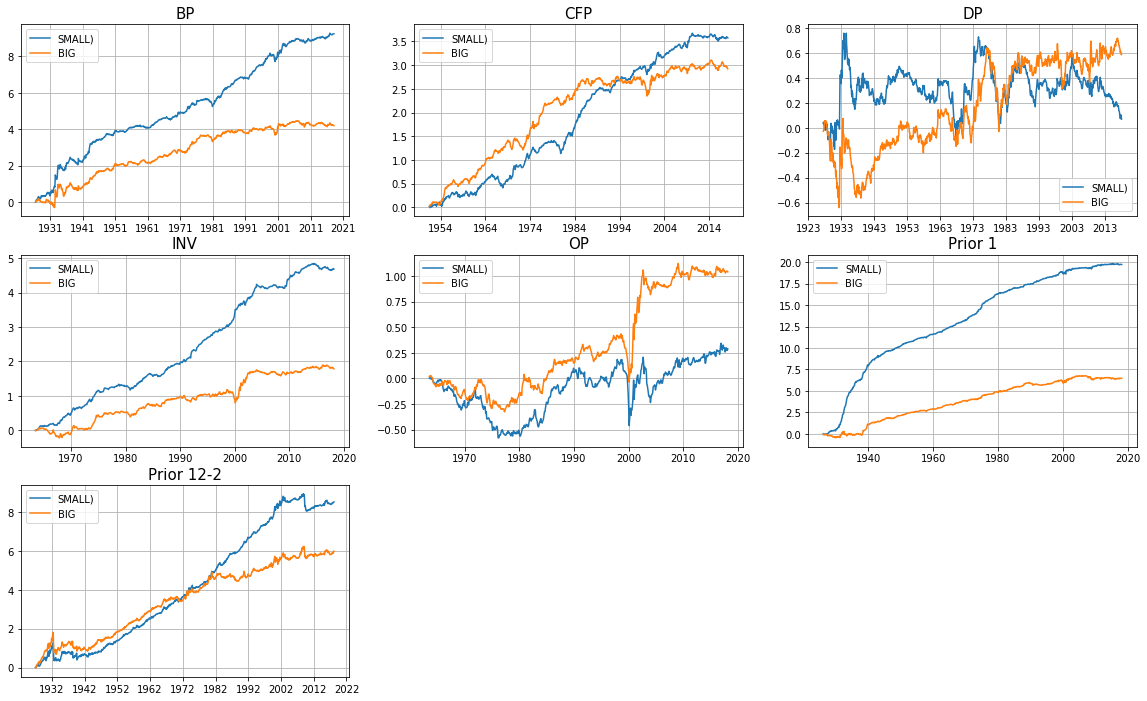

In [3]:
data1 = long_short('D:/PortfolioManagement/EW/BP_EW.csv')
data2 = long_short('D:/PortfolioManagement/EW/CFP_EW.csv')
data3 = long_short('D:/PortfolioManagement/EW/DP_EW.csv')
data4 = long_short('D:/PortfolioManagement/EW/INV_EW.csv',False)
data5 = long_short('D:/PortfolioManagement/EW/OP_EW.csv')
data6 = long_short('D:/PortfolioManagement/EW/MOMENTUM_PRIOR_1_EW.csv',False)
data7 = long_short('D:/PortfolioManagement/EW/MOMENTUM_PRIOR_12_2_EW.csv')



data_list = [data1,data2,data3,data4,data5,data6,data7]
factor_list = ['BP','CFP','DP','INV','OP','Prior 1','Prior 12-2']

plt.figure(figsize=(20,12))

for i in range(7):
    data = data_list[i]
    plt.subplot(3,3,i+1)
    plt.plot(data.index,data['SMALL'].cumsum()/100)
    plt.plot(data.index,data['BIG'].cumsum()/100)
    plt.legend(['SMALL)','BIG'])
    plt.title(factor_list[i],fontsize = 15)
    plt.grid(True)
    
plt.show()

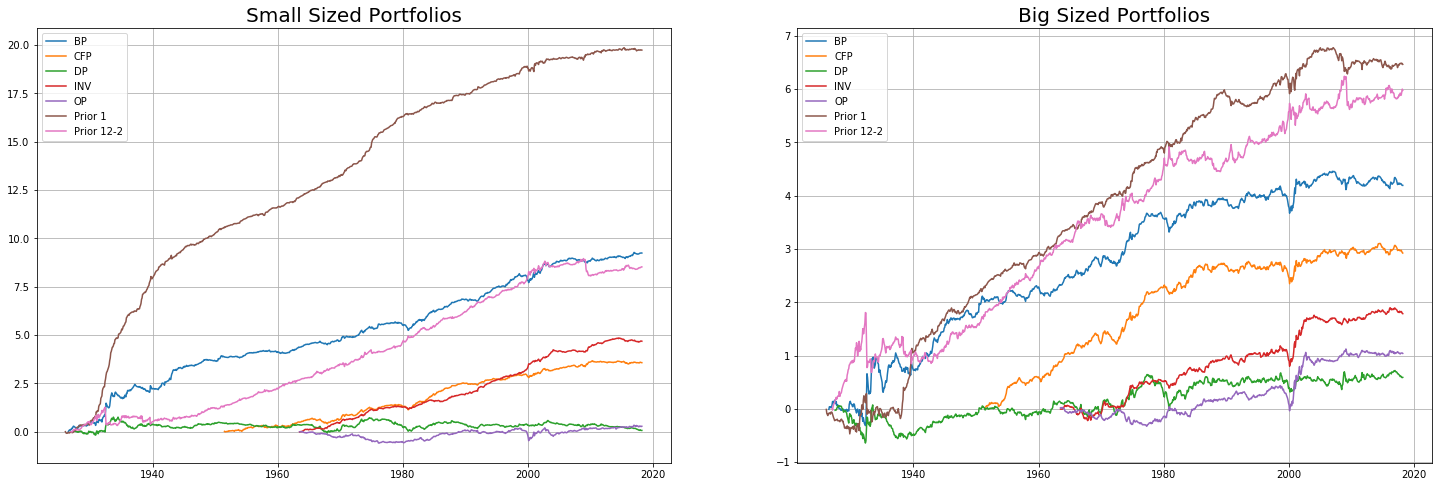

In [4]:
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
for i in range(7):
    data = data_list[i]
    plt.plot(data.index,data['SMALL'].cumsum()/100)
plt.legend(factor_list)
plt.title('Small Sized Portfolios',fontsize=20)
plt.grid(True)

plt.subplot(1,2,2)
for i in range(7):
    data = data_list[i]
    plt.plot(data.index,data['BIG'].cumsum()/100)
plt.legend(factor_list)
plt.title('Big Sized Portfolios',fontsize=20)
plt.grid(True)

plt.show()

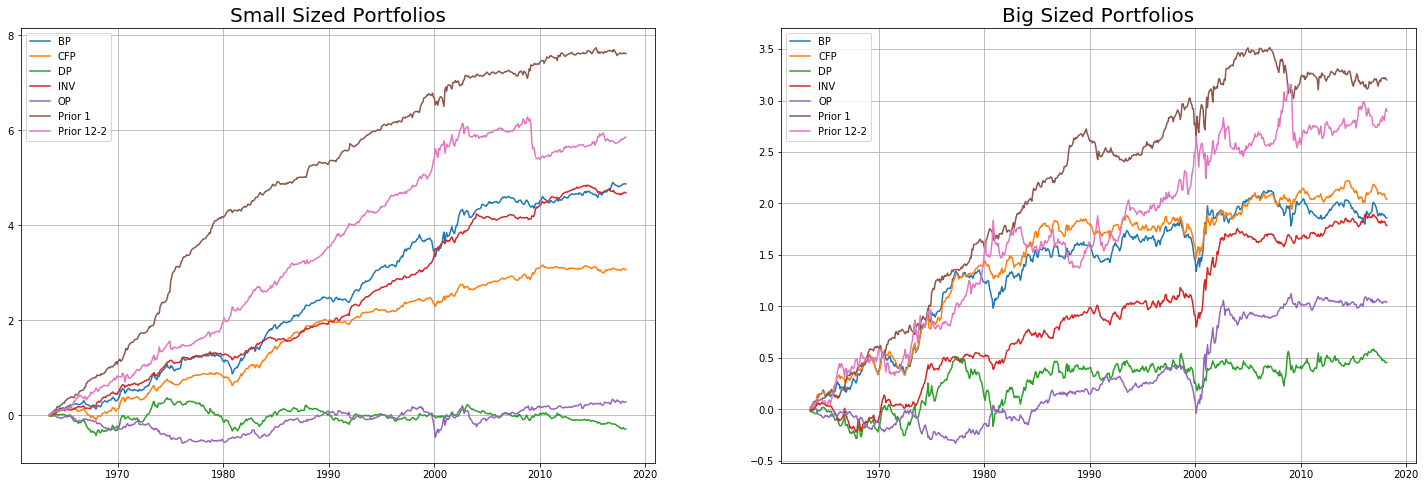

In [5]:
index_min = data4.index
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
for i in range(7):
    data = data_list[i].loc[index_min,:]
    plt.plot(data.index,data['SMALL'].cumsum()/100)
plt.legend(factor_list)
plt.grid(True)
plt.title('Small Sized Portfolios',fontsize=20)

plt.subplot(1,2,2)
for i in range(7):
    data = data_list[i].loc[index_min,:]
    plt.plot(data.index,data['BIG'].cumsum()/100)
plt.legend(factor_list)
plt.grid(True)
plt.title('Big Sized Portfolios',fontsize=20)

plt.show()

## 2. Statistics for Small and Big Risk Premia Factors (Equally-Weighted Factors）

In [6]:
big = pd.DataFrame()
small = pd.DataFrame()
market_data = pd.read_csv('D:/PortfolioManagement/F-F.csv')
market_data['MARKET'] = market_data['Mkt-RF'] + market_data['RF']
market_data['Month'] = pd.to_datetime(market_data['Month'],format ='%Y%m')
market_data = market_data.set_index('Month')

import numpy as np

index_min_1 = data4.index

for i in range(7):
    data=data_list[i].loc[index_min_1,:]
    data['RF'] =  market_data['RF']
    data['MARKET'] = market_data['MARKET']
    data['RM_RF'] = market_data['Mkt-RF']
    data['SMB'] = market_data['SMB']
    data['HML'] = market_data['HML']
    data['BIG_RF'] = data['BIG'] - data['RF']
    data['SMALL_RF'] = data['SMALL'] - data['RF']

    SMB = np.array(data['SMB'])
    HML = np.array(data['HML'])
    RM_RF = np.array(data['RM_RF'])
    
    X = np.column_stack((RM_RF,SMB,HML))
    
    Y_BIG = np.array(data['BIG_RF'] ).T
    Y_SMALL = np.array(data['SMALL_RF'] ).T
    
    X = sm.add_constant(X)
    MODEL_BIG = regression.linear_model.OLS(Y_BIG, X).fit()
    MODEL_SMALL = regression.linear_model.OLS(Y_SMALL, X).fit()

    data_big = data['BIG']
    data_small = data['SMALL']
    data_big_2 = data['BIG']-data['RF']
    data_small_2 = data['SMALL']-data['RF']
    data_big_3 = data['BIG']-data['MARKET']
    data_small_3 = data['SMALL']-data['MARKET']
    
    factor = factor_list[i] 
    
    rm_rf_mean = RM_RF.mean()
    rf_mean = data['RF'].mean()
    
    big.loc['Average Returns',factor] = data_big.mean()
    big.loc['Std',factor] = np.std(data_big)
    big.loc['Sharpe Ratio',factor] = data_big_2.mean()/np.std(data_big)
    big.loc['Alpha',factor] = MODEL_BIG.params[0]    
    big.loc['Beta',factor] = MODEL_BIG.params[1]
    big.loc['Treynor Ratio',factor] = data_big_2.mean()/MODEL_BIG.params[1]
    big.loc['Jensen Measure',factor] = data_big.mean()-rf_mean-MODEL_BIG.params[1]*rm_rf_mean
    big.loc['Information Ratio',factor] = data_big_3.mean()/np.std(data_big_3)
    
    small.loc['Average Returns',factor] = data_small.mean()
    small.loc['Std',factor] = np.std(data_small)
    small.loc['Sharpe Ratio',factor] = data_small_2.mean()/np.std(data_small)
    small.loc['Alpha',factor] = MODEL_SMALL.params[0]
    small.loc['Beta',factor] = MODEL_SMALL.params[1]
    small.loc['Treynor Ratio',factor] = data_small_2.mean()/MODEL_SMALL.params[1]
    small.loc['Jensen Measure',factor] = data_small.mean()-rf_mean-MODEL_SMALL.params[1]*rm_rf_mean
    small.loc['Information Ratio',factor] = data_small_3.mean()/np.std(data_small_3)


In [7]:
small

,BP,CFP,DP,INV,OP,Prior 1,Prior 12-2
Average Returns,0.741755,0.467230,-0.043516,0.713096,0.043937,1.159361,0.891446
Std,3.263751,2.148074,2.396207,2.014588,2.641278,3.347462,4.159649
Sharpe Ratio,0.109273,0.038228,-0.178879,0.162804,-0.129171,0.231294,0.121725
Alpha,0.229776,-0.008737,-0.342152,0.255604,-0.357176,0.607128,0.713121
Beta,-0.175379,-0.063741,-0.237741,-0.083232,0.069509,0.180160,-0.172492
Treynor Ratio,-2.033548,-1.288270,1.802929,-3.940581,-4.908415,4.297562,-2.935389
Jensen Measure,0.449226,0.115766,-0.303123,0.371922,-0.377871,0.679138,0.597393
Information Ratio,-0.026206,-0.081320,-0.156672,-0.038237,-0.168712,0.051934,-0.003369


In [8]:
big

,BP,CFP,DP,INV,OP,Prior 1,Prior 12-2
Average Returns,0.283262,0.310654,0.069543,0.271853,0.158469,0.487108,0.440959
Std,3.031750,2.705481,3.012706,2.402203,2.560425,3.381678,4.642842
Sharpe Ratio,-0.033595,-0.027522,-0.104747,-0.047149,-0.088519,0.030161,0.012028
Alpha,-0.440822,-0.298866,-0.345655,-0.217600,-0.142743,-0.065008,0.277264
Beta,0.001529,-0.046102,-0.251593,-0.088198,-0.086196,0.237535,-0.191074
Treynor Ratio,-66.609758,1.615120,1.254293,1.284163,2.629420,0.429384,-0.292267
Jensen Measure,-0.102660,-0.050122,-0.182751,-0.066700,-0.181141,-0.023404,0.156716
Information Ratio,-0.107438,-0.104709,-0.129878,-0.112567,-0.137114,-0.091660,-0.070061


## 3.  Beta of SMALL and BIG for Market Model

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: pd.rolling_cov is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36).cov(other=<Series>)
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36,center=False).var()


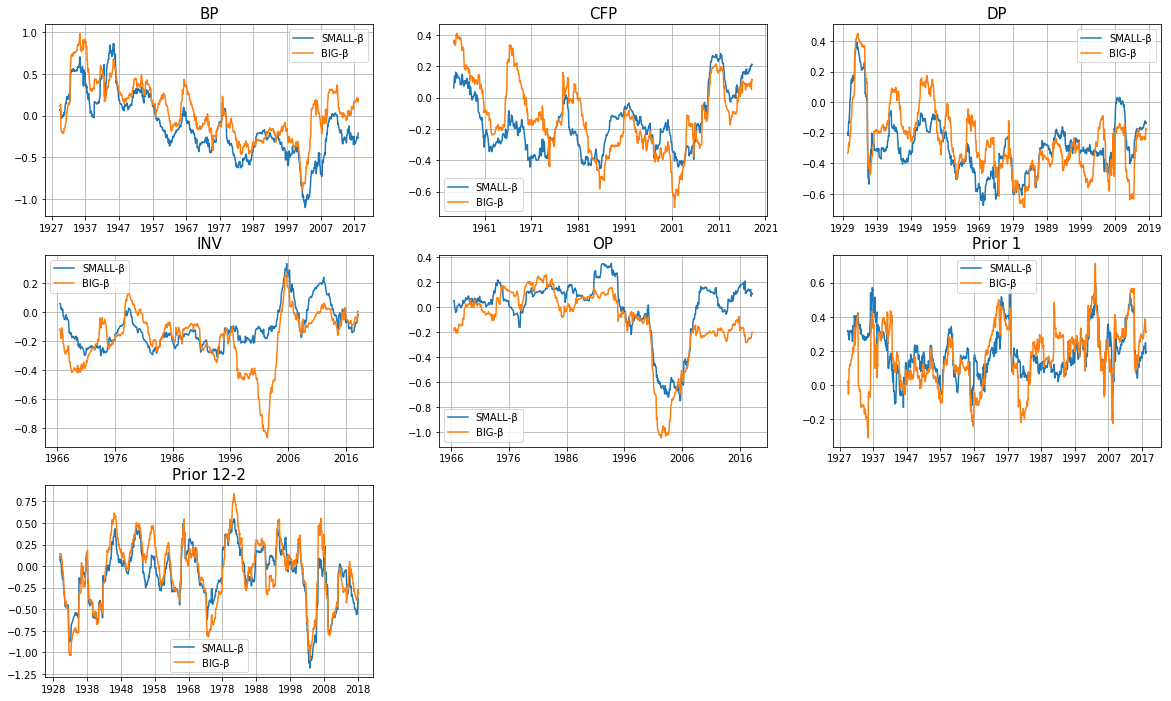

In [4]:
market_data = pd.read_csv('D:/PortfolioManagement/F-F.csv')
market_data['MARKET'] = market_data['Mkt-RF'] + market_data['RF']
market_data['Month'] = pd.to_datetime(market_data['Month'],format ='%Y%m')
market_data = market_data.set_index('Month')

data1,a1 = beta(data1,market_data)
data2,a2 = beta(data2,market_data)
data3,a3 = beta(data3,market_data)
data4,a4 = beta(data4,market_data)
data5,a5 = beta(data5,market_data)
data6,a6 = beta(data6,market_data)
data7,a7 = beta(data7,market_data)

a_list = [a1,a2,a3,a4,a5,a6,a7]
data_list=[data1,data2,data3,data4,data5,data6,data7]

plt.figure(figsize=(20,12))

for i in range(7):
    data = data_list[i]
    plt.subplot(3,3,i+1)
    plt.plot(data.index,data['SMALL_BETA'])
    plt.plot(data.index,data['BIG_BETA'])
    plt.legend(['SMALL-β','BIG-β'])
    plt.title(factor_list[i],fontsize = 15)
    plt.grid(True)
    
plt.show()


## 4. Performances for Beta-Neutral Portfolios of 7 Risk Premia Factors

### Beta-Neutral Portfolios are based on rolling dynamic Betas. 
### Holding a beta-neutral portfolio implies the investor can get an alpha without being exposed to any systematic risk.

In [5]:
output1 = beta_neutral_2(data1,a1)
output2= beta_neutral_2(data2,a2)
output3 = beta_neutral_2(data3,a3)
output4 = beta_neutral_2(data4,a4,False)
output5 = beta_neutral_2(data5,a5)
output6 = beta_neutral_2(data6,a6,False)
output7 = beta_neutral_2(data7,a7)

data_list = [data1,data2,data3,data4,data5,data6,data7]
output_list = [output1,output2,output3,output4,output5,output6,output7]


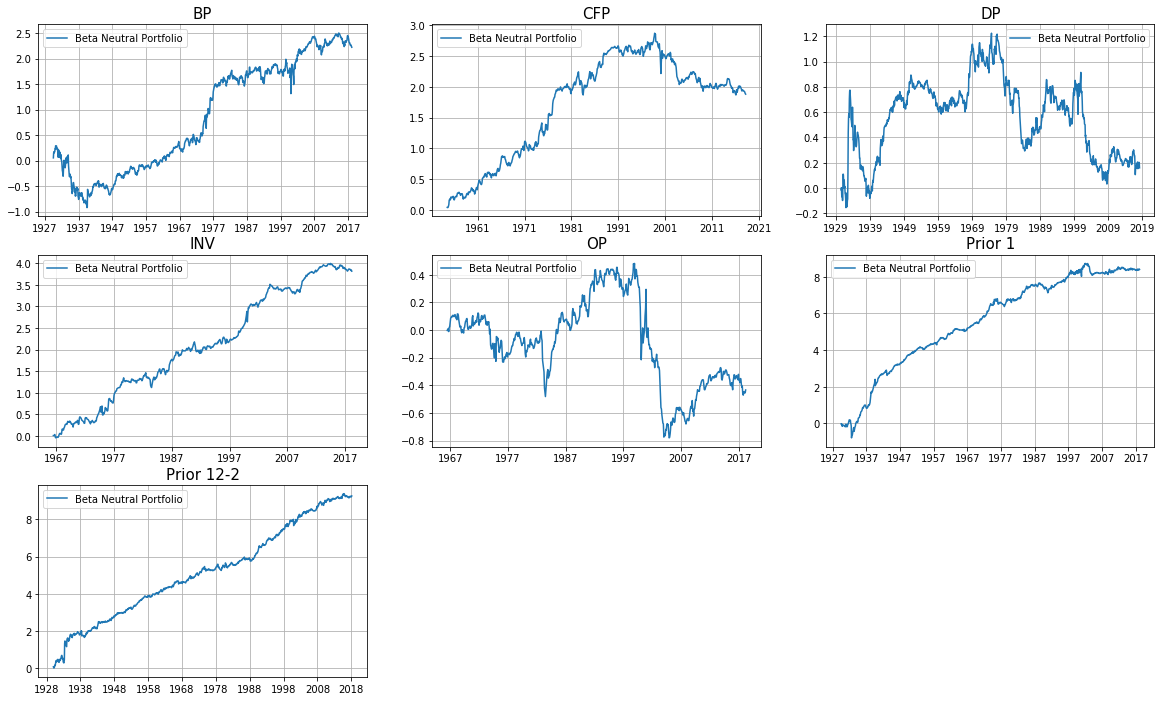

In [27]:

plt.figure(figsize=(20,12))

for i in range(7):
    output=output_list[i]
    plt.subplot(3,3,i+1)
    plt.plot(output.index,output['Beta_Neutral_Performance'].cumsum()/100)
    plt.legend(['Beta Neutral Portfolio'])
    plt.title(factor_list[i],fontsize = 15)
    plt.grid(True)
    
plt.show()

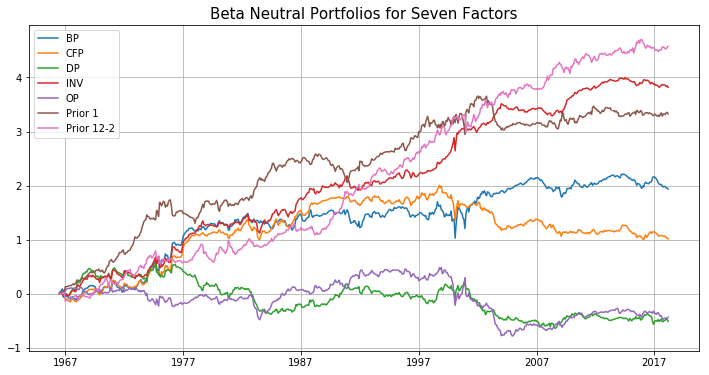

In [8]:
plt.figure(figsize=(12,6))
index_min_2 = data4.index[1:]
for i in range(7):
    output = output_list[i].loc[index_min_2,:]
    plt.plot(output.index,output['Beta_Neutral_Performance'].cumsum()/100)
    plt.legend(factor_list)
    plt.title('Beta Neutral Portfolios for Seven Factors',fontsize = 15)
plt.grid(True)
plt.show()
    

In [10]:
output_2 = pd.DataFrame()


import numpy as np

for i in range(7):
    data = output_list[i].loc[index_min_2,:]
    data['RF'] =  market_data['RF']
    data['MARKET'] = market_data['MARKET']
    data['RM_RF'] = market_data['Mkt-RF']
    data['SMB'] = market_data['SMB']
    data['HML'] = market_data['HML']
    data['BIG_RF'] = data['Beta_Neutral_Performance'] - data['RF']

    SMB = np.array(data['SMB'])
    HML = np.array(data['HML'])
    RM_RF = np.array(data['RM_RF'])
    
    X = np.column_stack((RM_RF,SMB,HML))
    
    Y = np.array(data['Beta_Neutral_Performance'] ).T    
    X = sm.add_constant(X)
    MODEL = regression.linear_model.OLS(Y, X).fit()

    data_p = data['Beta_Neutral_Performance']
    data_p_2 = data['Beta_Neutral_Performance']-data['RF']
    data_p_3 = data['Beta_Neutral_Performance']-data['MARKET']
    
    factor = factor_list[i] 
    
    rm_rf_mean = RM_RF.mean()
    rf_mean = data['RF'].mean()
    
    output_2.loc['Average Returns',factor] = data_p.mean()
    output_2.loc['Std',factor] = np.std(data_p)
    output_2.loc['Sharpe Ratio',factor] = data_p_2.mean()/np.std(data_p)
    output_2.loc['Alpha',factor] = MODEL.params[0]    
    output_2.loc['Beta',factor] = MODEL.params[1]
    output_2.loc['Treynor Ratio',factor] = data_p_2.mean()/MODEL.params[1]
    output_2.loc['Jensen Measure',factor] = data_p.mean()-rf_mean-MODEL.params[1]*rm_rf_mean
    output_2.loc['Information Ratio',factor] = data_p_3.mean()/np.std(data_p_3)


In [11]:
output_2

,BP,CFP,DP,INV,OP,Prior 1,Prior 12-2
Average Returns,0.311722,0.163409,-0.082319,0.614781,-0.069899,0.536486,0.737231
Std,4.357839,3.394123,3.345104,3.463404,3.575216,4.619919,4.124678
Sharpe Ratio,-0.017826,-0.066584,-0.141019,0.065074,-0.128469,0.031700,0.084328
Alpha,0.062331,0.047130,-0.091116,0.544450,-0.093230,NaN,0.814947
Beta,0.021329,0.017703,-0.011328,-0.032332,0.117748,NaN,-0.095644
Treynor Ratio,-3.642067,-12.766084,41.640411,-6.970796,-3.900718,NaN,-3.636660
Jensen Measure,-0.088897,-0.235303,-0.465767,0.242377,-0.521215,NaN,0.398116
Information Ratio,-0.091896,-0.126021,-0.167658,-0.050009,-0.176502,-0.063960,-0.027717


## 5. Performances for Equal-Risk Contribution Portfolios of 7 Risk Premia Factors

How to get a best portfolio is a popular and important question to answer.In the Efficient-Frontier problem, the tangency portfolio has a maximum Sharpe Ratio and is generally seen as the best portfolio, given expected returns and expected Correlation matrix. However, there is a large drawdown of the traditional tangency portfolio. The weights are highly dependent on inputed expected returns. Once there is a slight change in expected returns, it will lead to a very large change in outputed weights.

The reason why this happens is because the tangency portfolio is to minimize the total portfolio variance, and the stock which has large variance and large marginal covariance will always have a small weight.

#### To solve this problem, the Equal-Risk Contribution portfolio is introduced. All stocks have not negative weights. Besides, all stocks have equl risk contribution to the portfolio.

#### To get the ERC portfolio, optimization technique is applied to minimize the sum of differences of stocks' marginal risk contributions.

In [15]:
df = pd.DataFrame()

for i in range(7):
    df[factor_list[i]] =( data_list[i]['SMALL']+data_list[i]['BIG'])/2
df = df.dropna()


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


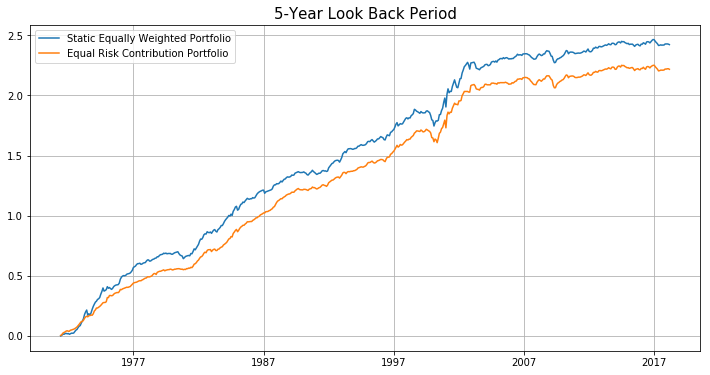

In [23]:
erc_df_1,simple_1,erc_list_1 = erc(df,60)
look_back = [1,2,3,4,5]
erc_df_all=[]
simple_all=[]
erc_all=[]

plt.figure(figsize=(12,6))
idx = erc_df_1.index[1:]
plt.plot(idx,pd.Series(simple_1).cumsum()/100)
plt.plot(idx,pd.Series(erc_list_1).cumsum()/100)
plt.legend(['Static Equally Weighted Portfolio','Equal Risk Contribution Portfolio'])
plt.title('5-Year Look Back Period',fontsize = 15)
plt.grid(True)
plt.show()

## Performances for ERC Portfolios with Varies Look-Back Periods

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


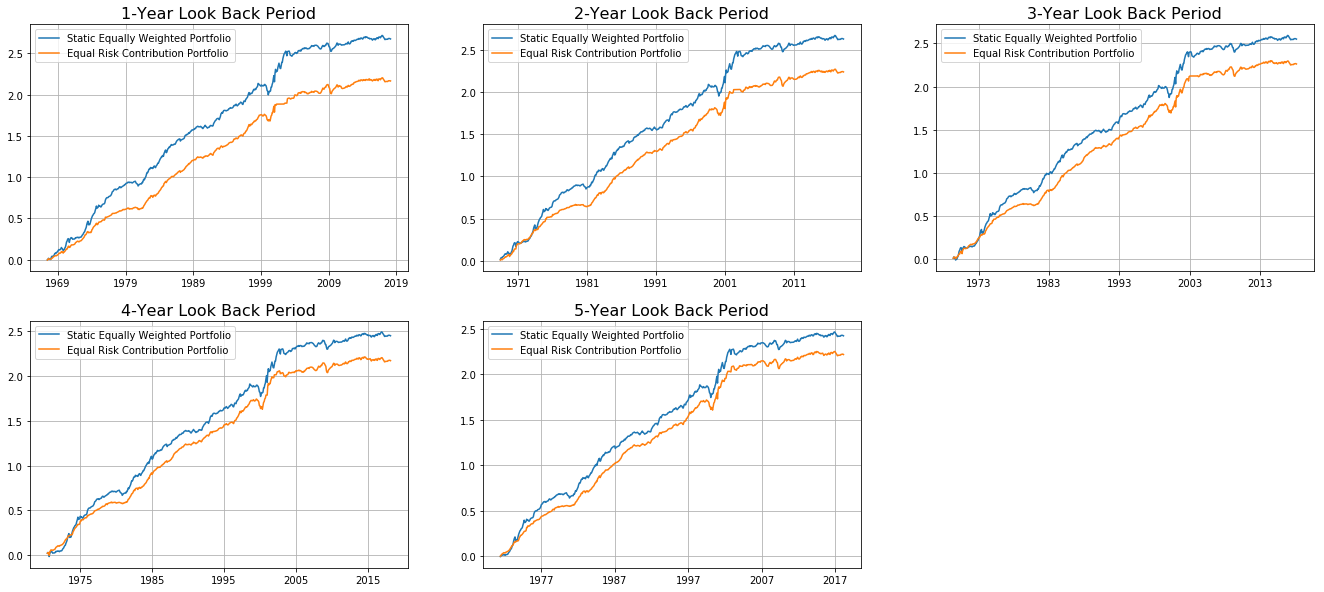

In [28]:

for i in range(5):
    year = look_back[i]
    erc_df,simple,erc_list = erc(df,12*year)
    erc_df_all.append(erc_df)
    simple_all.append(simple)
    erc_all.append(erc_list)


plt.figure(figsize=(23,10))

for i in range(5):
    year = look_back[i]
    erc_df = erc_df_all[i]
    simple = simple_all[i]
    erc_list = erc_all[i]
    plt.subplot(2,3,i+1)
    plt.plot(erc_df.index[1:],pd.Series(simple).cumsum()/100)
    plt.plot(erc_df.index[1:],pd.Series(erc_list).cumsum()/100)
    plt.legend(['Static Equally Weighted Portfolio','Equal Risk Contribution Portfolio'])
    plt.title(str(year)+'-Year Look Back Period',fontsize = 16)
    plt.grid(True)
    
plt.show()



## 6. Weights in ERC Portfolio

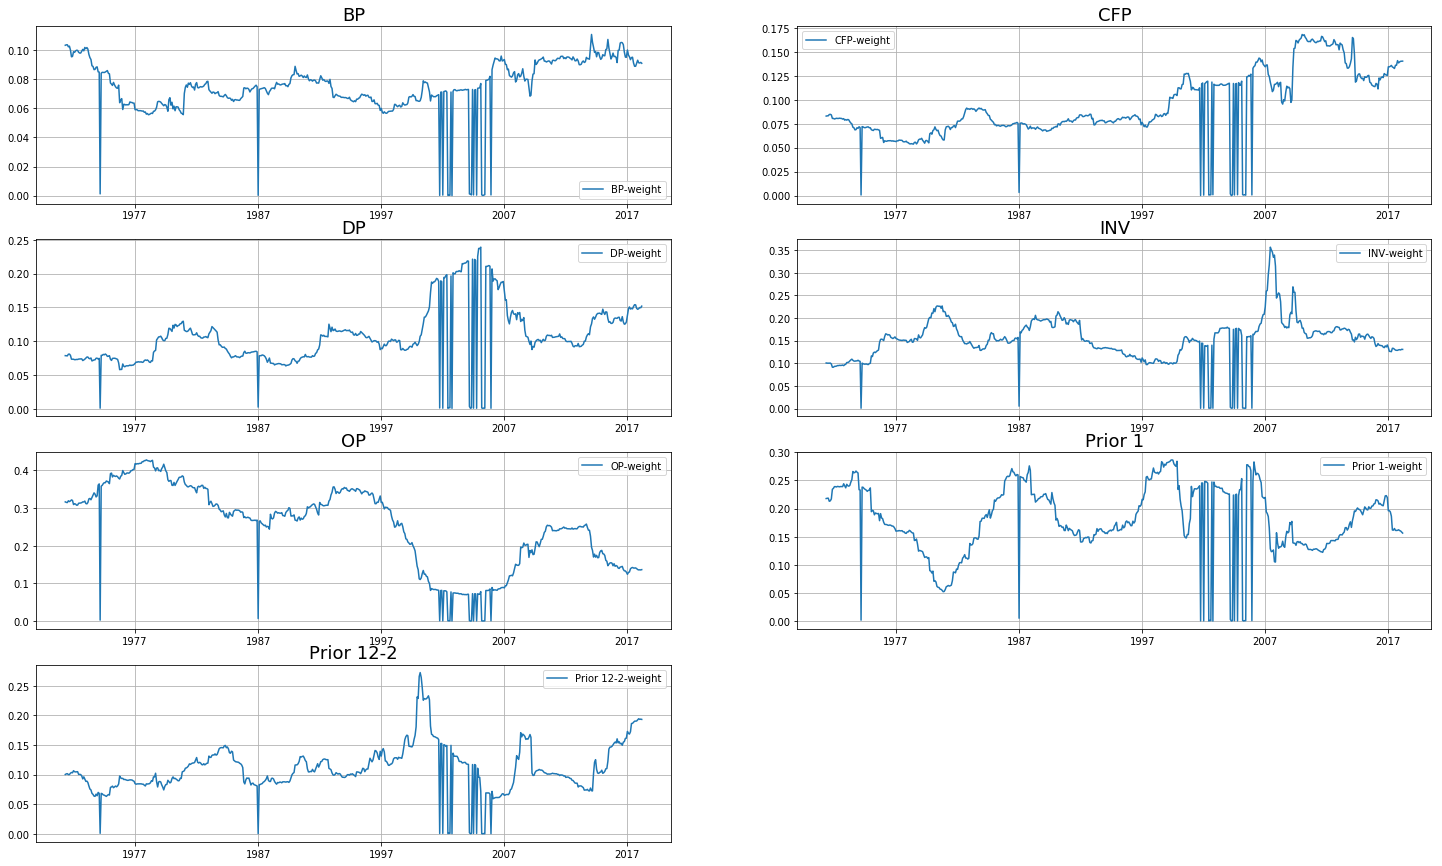

In [24]:
weights_columns = [i+'_weight' for i in factor_list]

plt.figure(figsize=(25,15))
for i in range(7):
    w = weights_columns[i]
    plt.subplot(4,2,i+1)
    plt.plot(erc_df_1.index,erc_df_1[w])
    plt.legend([factor_list[i]+'-weight'])
    plt.title(factor_list[i],fontsize = 18)
    plt.grid(True)
    
plt.show()

## 7. SAMPLE CORRELATION

In [27]:
df.corr()

,BP,CFP,DP,INV,OP,Prior 1,Prior 12-2
BP,1.000000,0.849261,0.674611,0.693908,0.080970,0.002582,-0.192215
CFP,0.849261,1.000000,0.661933,0.608805,0.219449,-0.054607,-0.117848
DP,0.674611,0.661933,1.000000,0.611033,0.056343,-0.094664,-0.195671
INV,0.693908,0.608805,0.611033,1.000000,-0.036048,-0.125791,-0.016750
OP,0.080970,0.219449,0.056343,-0.036048,1.000000,-0.086440,0.114908
Prior 1,0.002582,-0.054607,-0.094664,-0.125791,-0.086440,1.000000,-0.283565
Prior 12-2,-0.192215,-0.117848,-0.195671,-0.016750,0.114908,-0.283565,1.000000


##  8. Performances of Risk Premia Factor Based Portfolios

In [4]:
market_data = pd.read_csv('D:/PortfolioManagement/F-F.csv')
market_data['MARKET'] = market_data['Mkt-RF'] + market_data['RF']
market_data['Month'] = pd.to_datetime(market_data['Month'],format ='%Y%m')
market_data = market_data.set_index('Month')

In [5]:
df = pd.DataFrame()

for i in range(7):
    df[factor_list[i]] =( data_list[i]['SMALL']+data_list[i]['BIG'])/2
df = df.dropna()


In [6]:
look_back_periods = [1,2,3,4,5]

sharpe_ratio_long_short = []
sharpe_ratio_long_only = []

average_mean_long_short = []
average_mean_long_only = []

information_ratio_long_short = []
information_ratio_long_only = []

simple_all = []
df_all=[]
erc_all_data=[]

for year in look_back_periods:
    look_back =year*12
    erc_df,simple,erc_list = erc(df,12*year)
    erc_all_data.append(erc_list)
    
    
    data,x11,x12 = sharpe_ratio_equal(df,market_data,look_back,long_only=False)
    sharpe_ratio_long_short.append(x11)
    simple_all.append(x12)
    df_all.append(data)
    
    data,x21,x22 = sharpe_ratio_equal(df,market_data,look_back,long_only=True)
    
    sharpe_ratio_long_only.append(x21)
    
    average_mean_long_short.append(average_mean_equal(df,market_data,look_back,long_only=False))
    average_mean_long_only.append(average_mean_equal(df,market_data,look_back,long_only=True))
    
    information_ratio_long_short.append(information_ratio_equal(df,market_data,look_back,long_only=False))
    information_ratio_long_only.append(information_ratio_equal(df,market_data,look_back,long_only=True))
    

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


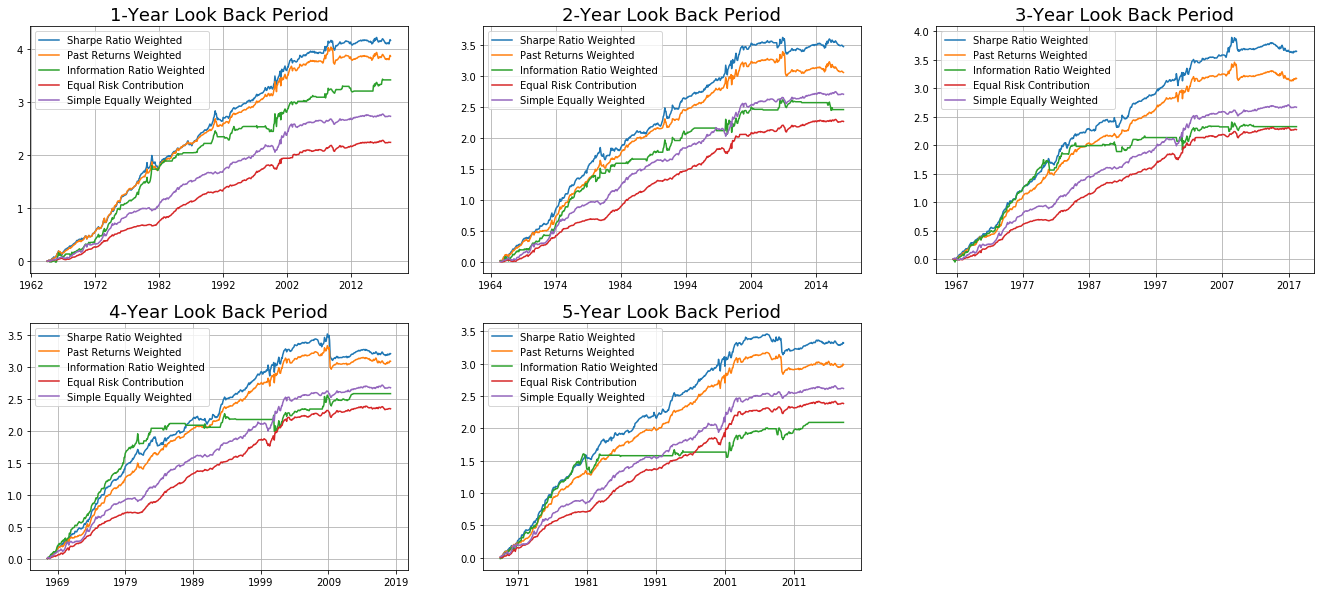

In [7]:
plt.figure(figsize=(23,10))

output_combine = []

for i in range(5):
    year = look_back_periods[i]
    sr = sharpe_ratio_long_only[i]
    am = average_mean_long_only[i]
    ir = information_ratio_long_only[i]
    si = simple_all[i]
    new_df = df_all[i]
    idx = new_df.index[1:]
    erc_list = erc_all_data[i]
    
    plt.subplot(2,3,i+1)
    plt.plot(idx,pd.Series(sr).cumsum()/100)
    plt.plot(idx,pd.Series(am).cumsum()/100)
    plt.plot(idx,pd.Series(ir).cumsum()/100)
    plt.plot(idx,pd.Series(erc_list).cumsum()/100)
    plt.plot(idx,pd.Series(si).cumsum()/100)
    plt.title(str(year)+'-Year Look Back Period',fontsize = 18)
    
    plt.legend(['Sharpe Ratio Weighted','Past Returns Weighted',\
                'Information Ratio Weighted','Equal Risk Contribution','Simple Equally Weighted'])

    plt.grid(True)
    
    data = pd.DataFrame()
    data['sr'] = pd.Series(sr,index=idx)
    data['am'] = pd.Series(am,index=idx)
    data['ir'] = pd.Series(ir,index=idx)
    data['erc'] = pd.Series(erc_list,index=idx)
    data['si'] = pd.Series(si,index=idx)
    
    
    
    data['RF'] =  market_data['RF']
    data['MARKET'] = market_data['MARKET']
    data['RM_RF'] = market_data['Mkt-RF']
    data['SMB'] = market_data['SMB']
    data['HML'] = market_data['HML']

    SMB = np.array(data['SMB'])
    HML = np.array(data['HML'])
    RM_RF = np.array(data['RM_RF'])
    
    X = np.column_stack((RM_RF,SMB,HML))
    X = sm.add_constant(X)
    
    factor_list_2 = ['sr','am','ir','erc','si']
    factor_full_name = ['Sharpe Ratio Weighted','Past Returns Weighted',\
                        'Information Ratio Weighted','Equal Risk Contribution','Simple Equally Weighted']
    
    output_3 = pd.DataFrame()
    for j in range(5):
        factor = factor_list_2[j]
        factor_full = factor_full_name[j]
        Y = np.array(data[factor] ).T    

        MODEL = regression.linear_model.OLS(Y, X).fit()

        data_p = data[factor]
        data_p_2 = data[factor]-data['RF']
        data_p_3 = data[factor]-data['MARKET']

        rm_rf_mean = RM_RF.mean()
        rf_mean = data['RF'].mean()

        output_3.loc['Average Returns',factor_full] = data_p.mean()
        output_3.loc['Std',factor_full] = np.std(data_p)
        output_3.loc['Sharpe Ratio',factor_full] = data_p_2.mean()/np.std(data_p)
        output_3.loc['Alpha',factor_full] = MODEL.params[0]    
        output_3.loc['Beta',factor_full] = MODEL.params[1]
        output_3.loc['Treynor Ratio',factor_full] = data_p_2.mean()/MODEL.params[1]
        output_3.loc['Jensen Measure',factor_full] = data_p.mean()-rf_mean-MODEL.params[1]*rm_rf_mean
        output_3.loc['Information Ratio',factor_full] = data_p_3.mean()/np.std(data_p_3)
    
    output_combine.append(output_3)

In [8]:
output_combine[0]

,Sharpe Ratio Weighted,Past Returns Weighted,Information Ratio Weighted,Equal Risk Contribution,Simple Equally Weighted
Average Returns,0.646187,0.600075,0.530572,0.348039,0.424207
Std,2.377167,2.403688,2.432164,0.955118,1.314044
Sharpe Ratio,0.109003,0.088616,0.059002,-0.040865,0.028262
Alpha,0.614601,0.596197,0.499280,0.316954,0.375700
Beta,-0.069530,-0.091566,-0.048778,-0.021275,-0.068762
Treynor Ratio,-3.726680,-2.326245,-2.941923,1.834554,-0.540091
Jensen Measure,0.294933,0.260172,0.168628,-0.028072,0.072557
Information Ratio,-0.048855,-0.056718,-0.072862,-0.117562,-0.093602


In [9]:
output_combine[1]

,Sharpe Ratio Weighted,Past Returns Weighted,Information Ratio Weighted,Equal Risk Contribution,Simple Equally Weighted
Average Returns,0.549117,0.483091,0.388495,0.358242,0.427546
Std,2.270413,2.279075,2.353345,1.002930,1.325066
Sharpe Ratio,0.070688,0.041449,-0.000056,-0.030295,0.029372
Alpha,0.553792,0.509856,0.372187,0.326206,0.377934
Beta,-0.080813,-0.110529,-0.051938,-0.020390,-0.069194
Treynor Ratio,-1.985965,-0.854666,0.002520,1.490116,-0.562474
Jensen Measure,0.202514,0.151941,0.026877,-0.019781,0.074901
Information Ratio,-0.068471,-0.079006,-0.101935,-0.115363,-0.093514


In [10]:
output_combine[2]

,Sharpe Ratio Weighted,Past Returns Weighted,Information Ratio Weighted,Equal Risk Contribution,Simple Equally Weighted
Average Returns,0.587510,0.510590,0.374552,0.366135,0.429333
Std,2.221848,1.991933,2.121046,0.988253,1.335885
Sharpe Ratio,0.089163,0.060838,-0.007002,-0.023546,0.029889
Alpha,0.581100,0.527117,0.329933,0.342721,0.379167
Beta,-0.073211,-0.093892,-0.027284,-0.029509,-0.069390
Treynor Ratio,-2.705938,-1.290698,0.544375,0.788544,-0.575421
Jensen Measure,0.236600,0.170554,-0.000507,-0.007753,0.076414
Information Ratio,-0.062588,-0.076905,-0.106655,-0.113910,-0.093744


In [44]:
output_combine[3]

,Sharpe Ratio Weighted,Past Returns Weighted,Information Ratio Weighted,Equal Risk Contribution Portfolio,Simple Equally Weighted
Average Returns,0.417721,0.354440,0.353950,0.351544,0.338191
Std,2.838203,2.260521,2.337596,1.429670,1.424255
Sharpe Ratio,0.011529,-0.013519,-0.013283,-0.023401,-0.032865
Alpha,0.482189,0.406925,0.362989,0.291301,0.273511
Beta,-0.109343,-0.117801,-0.057616,-0.066918,-0.068169
Treynor Ratio,-0.299253,0.259423,0.538911,0.499953,0.686657
Jensen Measure,0.097416,0.039139,0.003040,0.006138,-0.006475
Information Ratio,-0.100091,-0.114877,-0.117559,-0.119809,-0.122171


In [11]:
output_combine[4]

,Sharpe Ratio Weighted,Past Returns Weighted,Information Ratio Weighted,Equal Risk Contribution,Simple Equally Weighted
Average Returns,0.556491,0.500314,0.350775,0.399665,0.438524
Std,2.019738,1.800122,1.719645,1.074829,1.352189
Sharpe Ratio,0.082449,0.061300,-0.022791,0.009023,0.035910
Alpha,0.535468,0.487006,0.338639,0.358182,0.380003
Beta,-0.061503,-0.081192,-0.044961,-0.024501,-0.069100
Treynor Ratio,-2.707585,-1.359095,0.871676,-0.395819,-0.702709
Jensen Measure,0.197977,0.151869,-0.016199,0.022228,0.083895
Information Ratio,-0.067171,-0.076921,-0.110132,-0.103095,-0.088760
